In [39]:
%pip install opencv-python scikit-image tqdm

Note: you may need to restart the kernel to use updated packages.


In [40]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage.filters import threshold_niblack, threshold_sauvola, frangi
from skimage.morphology import remove_small_objects


In [41]:
DATASET_PATH = "DRIVE/training"

IMAGE_DIR = os.path.join(DATASET_PATH, "images")
GT_DIR = os.path.join(DATASET_PATH, "1st_manual")
FOV_DIR = os.path.join(DATASET_PATH, "mask")

image_files = sorted(os.listdir(IMAGE_DIR))
gt_files = sorted(os.listdir(GT_DIR))
fov_files = sorted(os.listdir(FOV_DIR))

print("Total training images:", len(image_files))
print("Total GT masks:", len(gt_files))
print("Total FOV masks:", len(fov_files))


Total training images: 20
Total GT masks: 20
Total FOV masks: 20


**Evaluation Metrics**

In [42]:
def sensitivity(gt, pred):

    gt = gt.flatten()
    pred = pred.flatten()

    TP = np.sum((gt == 1) & (pred == 1))
    FN = np.sum((gt == 1) & (pred == 0))

    return TP / (TP + FN + 1e-8)


def dice_score(gt, pred):

    gt = gt.flatten()
    pred = pred.flatten()

    intersection = np.sum(gt * pred)
    return (2 * intersection) / (np.sum(gt) + np.sum(pred) + 1e-8)


**Preprocess**

In [43]:
def preprocess(img):

    # Extract green channel
    green = img[:, :, 1]

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    green = clahe.apply(green)

    # Frangi vessel enhancement
    vessel_enhanced = frangi(green)

    # Normalize to 0-255
    vessel_enhanced = cv2.normalize(
        vessel_enhanced, None, 0, 255,
        cv2.NORM_MINMAX
    ).astype(np.uint8)

    return vessel_enhanced


**Postprocessing**

In [44]:
def postprocess(mask):

    mask = remove_small_objects(mask.astype(bool), min_size=50)

    kernel = np.ones((2,2), np.uint8)
    mask = cv2.morphologyEx(mask.astype(np.uint8),
                            cv2.MORPH_OPEN, kernel)

    return mask


**Segmentation functions**

In [45]:
def niblack_segmentation(img):

    thresh = threshold_niblack(img, window_size=25, k=-0.2)

    binary = img > thresh

    binary = postprocess(binary)

    return binary


In [46]:
def sauvola_segmentation(img):

    thresh = threshold_sauvola(img, window_size=25, k=0.2)

    binary = img > thresh

    binary = postprocess(binary)

    return binary


**Final evaluation**

In [47]:
results = []

for img_name, gt_name, fov_name in tqdm(
        zip(image_files, gt_files, fov_files),
        total=len(image_files)):

    img = cv2.imread(os.path.join(IMAGE_DIR, img_name))
    gt = cv2.imread(os.path.join(GT_DIR, gt_name), 0)
    fov = cv2.imread(os.path.join(FOV_DIR, fov_name), 0)

    img_p = preprocess(img)

    gt_binary = (gt > 127).astype(np.uint8)
    fov_mask = (fov > 0).astype(np.uint8)

    # Apply FOV mask
    gt_binary = gt_binary * fov_mask

    nib_pred = niblack_segmentation(img_p) * fov_mask
    sau_pred = sauvola_segmentation(img_p) * fov_mask

    results.append({
        "niblack_sensitivity": sensitivity(gt_binary, nib_pred),
        "sauvola_sensitivity": sensitivity(gt_binary, sau_pred),
        "niblack_dice": dice_score(gt_binary, nib_pred),
        "sauvola_dice": dice_score(gt_binary, sau_pred),
    })


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\rahul\AppData\Local\Temp\ipykernel_7892\2254217684.py:3: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask = remove_small_objects(mask.astype(bool), min_size=50)
100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


In [48]:
import pandas as pd

df = pd.DataFrame(results)

print("===== FINAL RESULTS =====")

print("\nSensitivity:")
print("Niblack:", df["niblack_sensitivity"].mean())
print("Sauvola:", df["sauvola_sensitivity"].mean())

print("\nDice Score:")
print("Niblack:", df["niblack_dice"].mean())
print("Sauvola:", df["sauvola_dice"].mean())


===== FINAL RESULTS =====

Sensitivity:
Niblack: 0.3786544301407521
Sauvola: 0.4686879819687695

Dice Score:
Niblack: 0.4675539969759238
Sauvola: 0.5009350706309987


**Visualization**

C:\Users\rahul\AppData\Local\Temp\ipykernel_7892\2254217684.py:3: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask = remove_small_objects(mask.astype(bool), min_size=50)


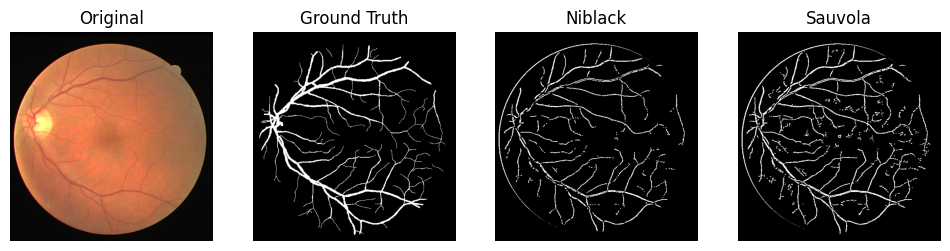

In [49]:
def show_sample(index=0):

    img_name = image_files[index]
    gt_name = gt_files[index]
    fov_name = fov_files[index]

    img = cv2.imread(os.path.join(IMAGE_DIR, img_name))
    gt = cv2.imread(os.path.join(GT_DIR, gt_name), 0)
    fov = cv2.imread(os.path.join(FOV_DIR, fov_name), 0)

    img_p = preprocess(img)

    gt_binary = (gt > 127).astype(np.uint8)
    fov_mask = (fov > 0).astype(np.uint8)
    gt_binary *= fov_mask

    nib_pred = niblack_segmentation(img_p) * fov_mask
    sau_pred = sauvola_segmentation(img_p) * fov_mask

    plt.figure(figsize=(12,4))

    plt.subplot(1,4,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(gt_binary, cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(nib_pred, cmap='gray')
    plt.title("Niblack")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(sau_pred, cmap='gray')
    plt.title("Sauvola")
    plt.axis("off")

    plt.show()

show_sample(0)
